In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
from function import fun1,fun2,fun3,fun4,fun5,fun6,fun7
from my_NN import *
import os
import matplotlib.pyplot as plt
import ycx_para_config as ycx

# 确保 model 文件夹存在
os.makedirs('./model_parameter', exist_ok=True)

debug=False

loss_list_final=[]

In [2]:
def sample_t_per_interval_and_generate_f_start(dtype,device,seg_step=16,batch_size=32,f_start_min=0.1,f_start_max=0.9):
    t_seg=torch.linspace(0,1,seg_step+1,dtype=dtype,device=device)
    t_seg=t_seg.repeat(batch_size,1)
    
    rand_move=torch.empty((batch_size,seg_step+1),dtype=dtype,device=device).uniform_(-ycx.random_amplititude/seg_step,ycx.random_amplititude/seg_step)
    #下面是满足正态分布的随机移动
    #rand_move = torch.randn((batch_size, seg_step + 1), dtype=dtype, device=device) * (ycx.random_amplititude / seg_step)

    
    rand_move[:,0]=0
    rand_move[:,-1]=0
    
    t_seg+=rand_move
    f_start_rand=torch.empty((batch_size,1),dtype=dtype,device=device).uniform_(f_start_min,f_start_max)
    
    return t_seg , f_start_rand


In [3]:
def boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=fun1,f_start_min=0.1,f_start_max=0.9):
    #注意这里t_seg还是size为(batch_size,seg_step+1)的tensor
    t_seg_copy=t_seg.clone()
    t_seg_copy=t_seg_copy.unsqueeze_(-1)
    temp_loss_list=[]
    
    log_step=int(np.log2(seg_step))
    
    delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
    func_f_end_value=boundary_func(f_start_rand)
    
    model_f_end_value=f_start_rand
    for i in range(seg_step):
        model_f_end_value=model_f_end_value + delta[:,i] * model.forward(model_f_end_value,t_seg_copy[:,i],delta[:,i])
        
    boundary_loss=loss_func(model_f_end_value,func_f_end_value)
    temp_loss_list.append(boundary_loss.item())  

    temp_step=seg_step
    if debug:print('log_step:',log_step)
    for i in range(log_step):
        t_seg_copy=t_seg_copy[:,::2]
        temp_step=temp_step//2
        delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
        model_f_end_value=f_start_rand
        for j in range(temp_step):
            model_f_end_value=model_f_end_value + delta[:,j] * model.forward(model_f_end_value,t_seg_copy[:,j],delta[:,j])
        if debug:print(f'step_boundary_loss steplen {2**(i+1)}:',loss_func(model_f_end_value,func_f_end_value).item())
        
        temp_loss_list.append(loss_func(model_f_end_value,func_f_end_value).item())
        
        boundary_loss+=loss_func(model_f_end_value,func_f_end_value)
        
    loss_list_final.append(temp_loss_list)
    if debug:print('boundary_loss:',boundary_loss.item())
    return boundary_loss
    

In [4]:
def get_loss(model,loss_func,batch_size,seg_step,dtype,device,boundary_func=fun1,f_start_min=0.1,f_start_max=0.6,consist_depth=5):
    use_consist_loss=False
    
    t_seg,f_start_rand=sample_t_per_interval_and_generate_f_start(dtype=dtype,device=device,seg_step=seg_step,batch_size=batch_size,f_start_min=f_start_min,f_start_max=f_start_max)
    
    boundary_loss=boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=boundary_func,f_start_min=f_start_min,f_start_max=f_start_max)
    loss=boundary_loss
    
    return loss
    

In [5]:
def iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=5,boundary_func=fun1):
    #train_loop
    optimizer.zero_grad()
    #计算loss
    #这里可以调节seg_step，f_start_min,f_start_max
    loss=get_loss(model,loss_func,batch_size,seg_step=ycx.choose_seg_step,dtype=dtype,device=device,boundary_func=boundary_func,consist_depth=consist_depth,f_start_min=ycx.f_start_min,f_start_max=ycx.f_start_max)
    #反向传播
    loss.backward()
    #更新参数
    optimizer.step()
    return loss.item()

In [6]:
def training(model,device='cuda',dtype=torch.float32,
          epoch=100,batch_size=32,lr=0.01,consist_depth=5,
          use_lr_scheduler=False,boundary_func=fun1):
    loss_list = []
    
    loss_func = nn.MSELoss()
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr,
                                 **({"fused": True} if "cuda" in str(device) else {}))#这里的fused=True，是为了使用apex加速

    # Use ReduceLROnPlateau as the learning rate scheduler
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               patience=ycx.lr_schedule_patience,
                                                               threshold=1e-4,
                                                               cooldown=ycx.lr_schedule_cooldown)
    
    init_time = time.time()
    for i in range(epoch):
        for _ in range(ycx.iteration_num):
            loss_term=iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=consist_depth,boundary_func=boundary_func)
            #设计中，iteration中已经完成反向传播，所以这里不需要再进行反向传播
            loss_list.append(loss_term)
        if (i+1)%20==0:
            print(f'epoch:{i+1},loss:{loss_term},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        if (i+1)%50==0:
            torch.save(model.state_dict(),ycx.only_boundary_para_file_name)
        if use_lr_scheduler:
            scheduler.step(loss_term)
        if optimizer.param_groups[0]["lr"] <= 1.1e-8:
            break
    print('terminal epoch: ',i+1)
    torch.save(model.state_dict(),ycx.only_boundary_para_file_name)
    
    if debug==False:
        plt.plot(loss_list,label='loss')
        plt.legend()
    pass

now using cuda !
model_name: Mynetwork_2_128
use_function_name: fun1
batch_size: 128
iteration_num: 4
choose_seg_step: 16
random_amplititude: 0.3
epoch:20,loss:0.41027024388313293,time:2.340203285217285,lr:0.01
epoch:40,loss:0.5628853440284729,time:4.477196216583252,lr:0.01
epoch:60,loss:0.2976239323616028,time:6.636404275894165,lr:0.01
epoch:80,loss:0.034452956169843674,time:8.783777713775635,lr:0.01
epoch:100,loss:0.018209900707006454,time:10.936568975448608,lr:0.001
epoch:120,loss:0.03968742489814758,time:13.076639890670776,lr:0.001
epoch:140,loss:0.01918780244886875,time:15.228332757949829,lr:0.001
epoch:160,loss:0.025848975405097008,time:17.370320081710815,lr:0.0001
epoch:180,loss:0.039173148572444916,time:19.51431393623352,lr:1e-05
epoch:200,loss:0.023804401978850365,time:21.646435260772705,lr:1e-05
epoch:220,loss:0.016219094395637512,time:23.79932451248169,lr:1.0000000000000002e-06
epoch:240,loss:0.021235736086964607,time:25.94464373588562,lr:1.0000000000000002e-07
terminal epoc

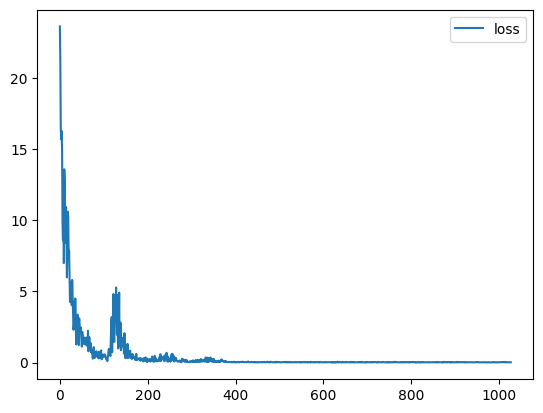

In [7]:
if __name__=='__main__':
    initial_time=time.time()
    if torch.cuda.is_available():
        device='cuda'
        print('now using cuda !')
    else:
        device='cpu'
        print('now using cpu !')
        
    dtype=torch.float32
    model=ycx.NN().to(device=device,dtype=dtype)
    #初始化网络参数
    from torch.nn import init
    for name, param in model.named_parameters():
        if 'weight' in name:
            init.normal_(param, mean=0, std=0.1)
        elif 'bias' in name:
            init.constant_(param, val=0)
            
            
    print('model_name:',model.name)
    print('use_function_name:',ycx.function_name)
    print('batch_size:',ycx.batch)
    print('iteration_num:',ycx.iteration_num)
    print('choose_seg_step:',ycx.choose_seg_step)
    print('random_amplititude:',ycx.random_amplititude)
    ############################################################
    #设置超参数
    batch_size=ycx.batch
    epoch=ycx.epoch
    if debug:epoch=ycx.debug_epoch
    consist_depth=5
    #training part 
    training(model,device,dtype,epoch=epoch,lr=ycx.lr,batch_size=batch_size,consist_depth=consist_depth,use_lr_scheduler=ycx.use_lr_schedule,boundary_func=ycx.choose_fun)
    
    print('program ended here \n terminal time: ', time.time()-initial_time)
    print('save model parameter in file name :',f' batch{batch_size}_epoch{epoch}.pth')
    

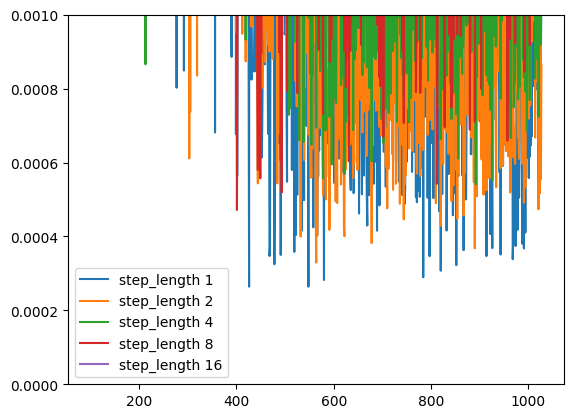

In [8]:
list_length=len(loss_list_final)
x=np.array([i for i in range(list_length)])
loss_list_final=np.array(loss_list_final)

end=5000
begin=100
begin=max(0,begin)
end=min(end,list_length)
for i in range(loss_list_final.shape[1]): 
    plt.plot(x[begin:end],loss_list_final[begin:end,i],label=f'step_length {2**i}')
plt.ylim(0,0.001)
plt.legend()
plt.show()